In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../dataset/numerical_data.csv') #only use with full dataset

FEATURE = 'xas'

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               155361 non-null  float64
 7   formation_energy_per_atom                     155361 non-null  float64
 8   energy_above_hull                             155361 non-null  float64
 9   is_stable                                     15

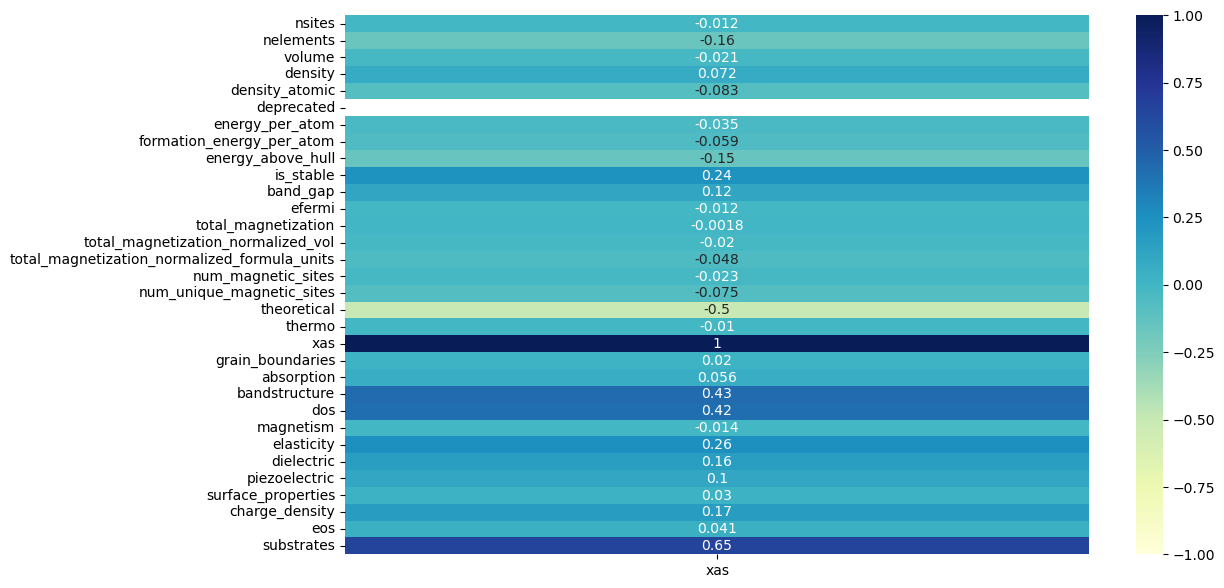

In [4]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
numerical_df.drop(columns=["cbm", "vbm"], inplace=True)#drop null values


plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[[FEATURE]]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [5]:
print((numerical_df['xas'] == 0).sum())
print((numerical_df['xas'] != 1).sum())


94441
94441


In [6]:
from sklearn.tree import DecisionTreeRegressor

# Split data into real and theoretical subsets and model on real values first
real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

# Drop 'theoretical' column
real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

# set the feature names
feature_names = numerical_df.drop(['xas', 'theoretical'], axis=1).columns.tolist()


print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)
print("Feature names:", feature_names)


Real df shape: (49772, 31)
Theoretical df shape: (105589, 31)
Feature names: ['nsites', 'nelements', 'volume', 'density', 'density_atomic', 'deprecated', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'band_gap', 'efermi', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'thermo', 'grain_boundaries', 'absorption', 'bandstructure', 'dos', 'magnetism', 'elasticity', 'dielectric', 'piezoelectric', 'surface_properties', 'charge_density', 'eos', 'substrates']


In [7]:
print(real_df[FEATURE].isnull().sum())

0


In [8]:
#Train a model for FEATURE on real molecules

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error


# Select data corresponding to features in feature_names
X = real_df[feature_names]
y = real_df[FEATURE]

X = real_df[feature_names]
y = real_df[FEATURE]
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=1)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = real_df[feature_names]
y = real_df[FEATURE] 

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=1)

dtr_model = DecisionTreeRegressor(
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=20, #Best performance on theoretical set with 20
    min_samples_leaf=20,#Best performance on theoretical set with 20
    max_features='sqrt',
    criterion='squared_error',
)

rfe = RFE(estimator=dtr_model, n_features_to_select=15) #15 works best - everything higher or lower does worse
rfe.fit(train_X, train_y)

selected_features = rfe.support_

train_X_selected = train_X.iloc[:, selected_features]
test_X_selected = test_X.iloc[:, selected_features]

dtr_model.fit(train_X_selected, train_y)
predictions = dtr_model.predict(test_X_selected)

# Evaluate the model
mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

# Print evaluation metrics
print(f"MSE: {mse}")
print("MAE: ", mae)
print(f"R2: {r2}")

MSE: 0.13513625739743562
MAE:  0.24608495644717507
R2: 0.27165417563762406


In [10]:
theoretical_x = theoretical_df[feature_names]

theoretical_x_selected = theoretical_x.iloc[:, selected_features]
theoretical_predictions = dtr_model.predict(theoretical_x_selected)
theoretical_y = theoretical_df['xas']

mse_theoretical = mean_squared_error(theoretical_y, theoretical_predictions)
mae_theoretical = mean_absolute_error(theoretical_y, theoretical_predictions)
r2_theoretical = r2_score(theoretical_y, theoretical_predictions)

print(f"Theoretical  MSE: {mse_theoretical}")
print(f"Theoretical MAE: {mae_theoretical}")
print(f"Theoretical r2: {r2_theoretical}")

Theoretical  MSE: 0.3369703600297495
Theoretical MAE: 0.48826563656503397
Theoretical r2: -0.9362406713879703


In [11]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=10, #Best performance on theoretical set with 10
    min_samples_leaf=20,#Best performance on theoretical set with 20
    max_features='sqrt',
    criterion='squared_error',
    n_estimators=250 #best performed with 250
)

rf_model.fit(train_X_selected, train_y)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=20,
                      min_samples_split=10, n_estimators=250)

In [12]:
rf_model.fit(train_X_selected, train_y)
predictions = rf_model.predict(test_X_selected)

# Evaluate the model
mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

# Print evaluation metrics
print(f"MSE: {mse}")
print("MAE: ", mae)
print(f"R2: {r2}")

MSE: 0.11351048854278598
MAE:  0.23983375888910952
R2: 0.3882108921492128


In [13]:
#Now predict xas with the theoretical elements with Random Forrest Regressor

theoretical_predictions = rf_model.predict(theoretical_x_selected)

# Evaluating the Forrest model against theoretical data
mse = mean_squared_error(theoretical_y, theoretical_predictions)
mae = mean_absolute_error(theoretical_y, theoretical_predictions)
r2 = r2_score(theoretical_y, theoretical_predictions)

print(f'MSE: {mse}')
print("MAE: ", mae)
print(f'R2: {r2}')

MSE: 0.2694865411172305
MAE:  0.4514932925917382
R2: -0.5484768489928369


In [14]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [15]:
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=1)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(train_X)
scaled_X_test = scaler.transform(test_x)

In [ ]:
dnn_model = Sequential()
dnn_model.add(Dense(64, activation="relu", input_dim=scaled_X_train.shape[1]))  # Input layer
dnn_model.add(Dense(32, activation="relu"))  # Hidden layer 1
dnn_model.add(Dense(1))  # Output layer (no activation for regression)

dnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mean_squared_error")

dnn_model.fit(scaled_X_train, train_y, epochs=100, batch_size=32, validation_split=0.2)

mse = dnn_model.evaluate(scaled_X_test, test_y)
print("Mean Squared Error:", mse)

dnn_predictions = dnn_model.predict(scaled_X_test)
r2 = r2_score(test_y, dnn_predictions)


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 1.0626 - val_loss: 0.1832
Epoch 2/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 0.1687 - val_loss: 0.1485
Epoch 3/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 0.1459 - val_loss: 0.1387
Epoch 4/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - loss: 0.1374 - val_loss: 0.1334
Epoch 5/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - loss: 0.1323 - val_loss: 0.1299
Epoch 6/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.1289 - val_loss: 0.1285
Epoch 7/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 0.1277 - val_loss: 0.1273
Epoch 8/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - loss: 0.1239 - val_loss: 0.1263
Epoch 9/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.1231 - val_loss: 0.1271
Epoch 10/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - loss: 0.1220 - val_loss: 0.1251
Epoch 11/100
996/996 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 0.1223 - val_loss: 0.1252
Epoch 12/100
996/996 ━━━━━━━━━━

In [ ]:
print(r2)

0.3550277352333069
